In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('colores.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 10, 150)

canny = cv2.dilate(canny, None, iterations=1)
canny = cv2.erode(canny, None, iterations=1)

contorno, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rect = image.copy()
img_ellipse = image.copy()
img_circle = image.copy()
img_divider = image.copy()

for i, c in enumerate(contorno):
    epsilon = 0.01 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)

    M = cv2.moments(c)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)

    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.drawContours(mask, [c], -1, 255, -1)
    mean_val = cv2.mean(image, mask=mask)
    color = tuple(int(v) for v in mean_val[:3])  # BGR

    x, y, w, h = cv2.boundingRect(approx)

    # Rectángulo
    cv2.rectangle(img_rect, (x, y), (x + w, y + h), color, 2)

    # Elipse
    if len(c) >= 5:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(img_ellipse, ellipse, color, 2)

    # Círculo
    (x_circle, y_circle), radius = cv2.minEnclosingCircle(c)
    center_circle = (int(x_circle), int(y_circle))
    radius = int(radius)
    cv2.circle(img_circle, center_circle, radius, color, 2)

    # Línea divisora (horizontal y vertical)
    cv2.line(img_divider, (cx, cy - 50), (cx, cy + 50), color, 2)  # vertical
    cv2.line(img_divider, (cx - 50, cy), (cx + 50, cy), color, 2)  # horizontal

    print(f'Contorno {i+1}: Área: {area:.2f}, Perímetro: {perimetro:.2f}, Centroide: ({cx},{cy})')

# Mostrar las 4 imágenes
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
plt.title('Rectángulo Inscrito')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(img_ellipse, cv2.COLOR_BGR2RGB))
plt.title('Elipse Ajustada')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img_circle, cv2.COLOR_BGR2RGB))
plt.title('Círculo Circunscrito')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(img_divider, cv2.COLOR_BGR2RGB))
plt.title('Líneas Divisoras por Centroide')
plt.axis('off')

plt.tight_layout()
plt.show()


In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('pose1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

color_changed = cv2.bitwise_not(image)

kernel_prop = np.array([[0, -1, 0],
                        [-1, 5, -1],
                        [0, -1, 0]])
convol_prop = cv2.filter2D(image, -1, kernel_prop)

convol_predef = cv2.GaussianBlur(image, (7, 7), 0)

eye_left_roi = image[850:1050,920:1250,:]  # Cambia estos valores según tu rostro
eye_gray = cv2.cvtColor(eye_left_roi, cv2.COLOR_BGR2GRAY)
eye_canny = cv2.Canny(eye_gray, 25, 70)

fog = image.copy()
h, w = fog.shape[:2]
noise = np.random.normal(0, 30, (h, w, 1)).astype(np.uint8)
noise = cv2.merge([noise]*3)
foggy = cv2.addWeighted(fog, 0.7, noise, 0.3, 0)

# 8. Detección de bordes en toda la imagen
edges = cv2.Canny(gray, 50, 150)

# 9. Área, perímetro, centroide, inscripción en cuadro rosa
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
analyzed = image.copy()

for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0

    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(analyzed, (x, y), (x + w, y + h), (255, 0, 255), 2)  # Rosa
    cv2.circle(analyzed, (cx, cy), 5, (0, 255, 0), -1)
    print(f"Área: {area:.2f}, Perímetro: {perimeter:.2f}, Centroide: ({cx},{cy})")

# Mostrar resultados
plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1) 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Umbralización')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(cv2.cvtColor(color_changed, cv2.COLOR_BGR2RGB))
plt.title('Cambio de Color')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(cv2.cvtColor(convol_prop, cv2.COLOR_BGR2RGB))
plt.title('Kernel Propio')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(convol_predef, cv2.COLOR_BGR2RGB))
plt.title('Kernel Predefinido')
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(eye_canny, cmap='gray')
plt.title('Canny en Ojo Izquierdo')
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(cv2.cvtColor(foggy, cv2.COLOR_BGR2RGB))
plt.title('Filtro de Neblina')
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(edges, cmap='gray')
plt.title('Detección de Bordes')
plt.axis('off')

plt.subplot(3, 3, 9)
plt.imshow(cv2.cvtColor(analyzed, cv2.COLOR_BGR2RGB))
plt.title('Contorno y Centroide')
plt.axis('off')

# Ajustar diseño para que no se solapen
plt.tight_layout()
plt.show()



error: OpenCV(4.11.0) D:\bld\libopencv_1743559210376\work\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


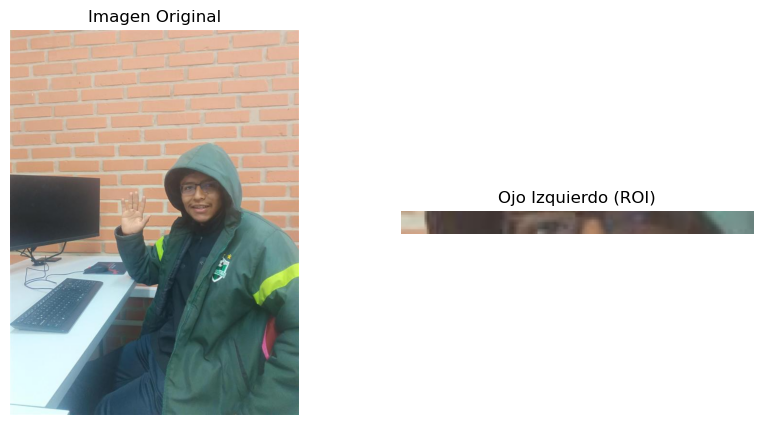

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('pose1.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#eye_left_roi = img[850:1050,920:1250,:]
eye_left_roi = img[320:330, 310:460,:]  # Cambia estos valores según tu rostro

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis('off')  # Para que no aparezcan los ejes

eye_left_roi_rgb = cv2.cvtColor(eye_left_roi, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 2)
plt.imshow(eye_left_roi_rgb)
plt.title("Ojo Izquierdo (ROI)")
plt.axis('off')

plt.show()


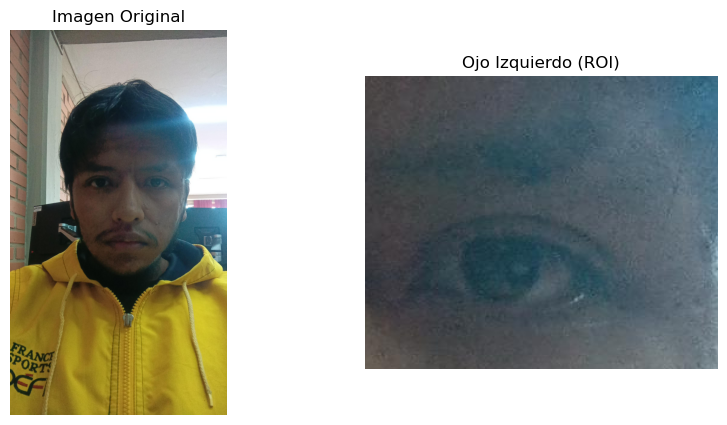

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('rostro1j.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

eye_left_roi = img[850:1100,850:1150,:]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Imagen Original")
plt.axis('off')  # Para que no aparezcan los ejes

eye_left_roi_rgb = cv2.cvtColor(eye_left_roi, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 2)
plt.imshow(eye_left_roi_rgb)
plt.title("Ojo Izquierdo (ROI)")
plt.axis('off')

plt.show()


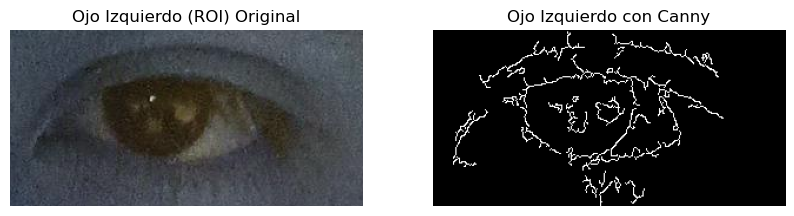

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('rostro_J.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

eye_left_roi = img[900:1050,950:1250,:]
#eye_left_roi = img[900:1150,950:1250,:]

eye_left_gray = cv2.cvtColor(eye_left_roi, cv2.COLOR_BGR2GRAY)

eye_left_blur = cv2.GaussianBlur(eye_left_gray, (5, 5), 0)

edges = cv2.Canny(eye_left_blur, 25, 70)  # Umbrales más bajos

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(eye_left_roi)
plt.title("Ojo Izquierdo (ROI) Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Ojo Izquierdo con Canny")
plt.axis('off')

plt.show()


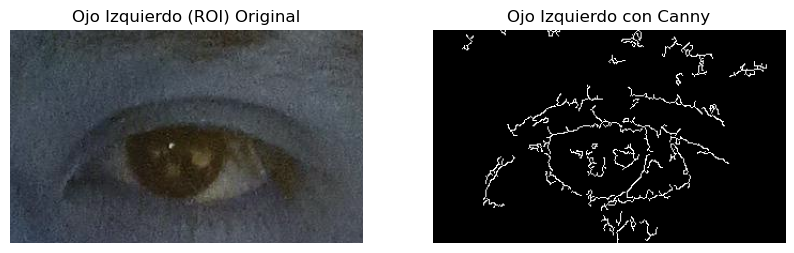

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('rostro_J.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

eye_left_roi = img[850:1050, 920:1250, :]

eye_left_gray = cv2.cvtColor(eye_left_roi, cv2.COLOR_BGR2GRAY)

eye_left_blur = cv2.GaussianBlur(eye_left_gray, (5, 5), 0)

edges = cv2.Canny(eye_left_blur, 25, 70)  # Umbrales más bajos

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(eye_left_roi)
plt.title("Ojo Izquierdo (ROI) Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Ojo Izquierdo con Canny")
plt.axis('off')

plt.show()


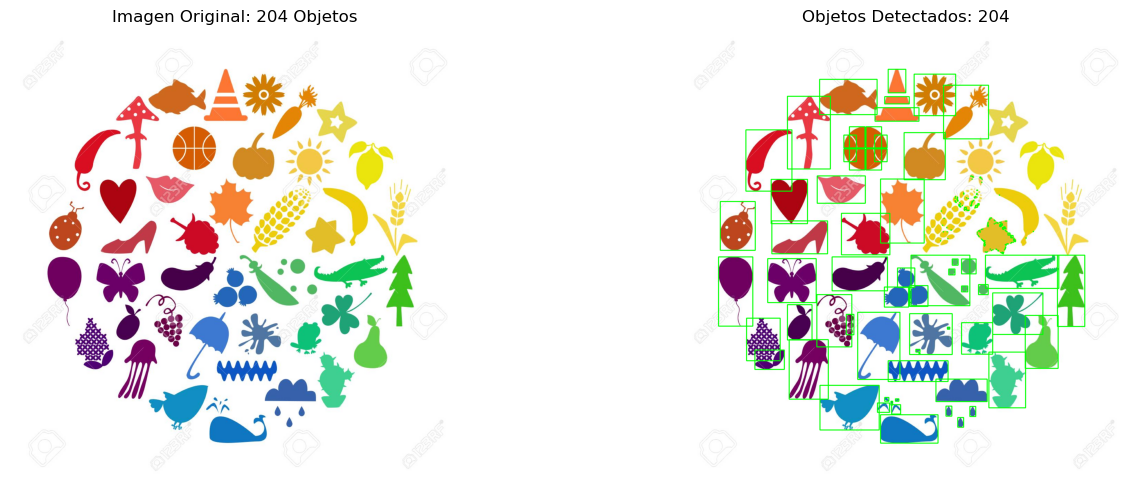

Objetos encontrados: 204


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen
img = cv2.imread('elementos.jpg')

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización binaria usando Otsu
_, binaria = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Encontrar los contornos de los objetos
contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contamos los objetos encontrados
num_objetos = len(contornos)

# Crear una copia de la imagen original para dibujar los rectángulos
img_contornos = img.copy()

# Dibujar un rectángulo alrededor de cada objeto detectado
for i, contorno in enumerate(contornos):
    # Obtener el rectángulo delimitador de cada contorno
    x, y, w, h = cv2.boundingRect(contorno)
    
    # Dibujar el rectángulo en la imagen
    cv2.rectangle(img_contornos, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectángulo verde

# Mostrar la imagen con los contornos y rectángulos
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title(f'Imagen Original: {num_objetos} Objetos')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Objetos Detectados: {num_objetos}')
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Imprimir el número de objetos detectados
print(f'Objetos encontrados: {num_objetos}')
